In [442]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy.stats import norm
from scipy.special import factorial
from tqdm import tqdm

In [483]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [527]:
# Reading channels
data = pd.read_csv('datos.csv',sep=',')
n = np.array(data.n)
b = np.array(data.b)
s = np.array(data.s)
N = n.shape[0]
data

,n,b,s
0,105,100,10


In [528]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [529]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [552]:
def GetObsJointLnQ(LnQ,mu,Expected = True):

    Q = 0.
    # The observed LnQ is defined for mu == 1!!!!
    
    for c in range(N):

        if Expected: # Observed events are the expected background
            Q += LnQ( b[c], b[c], s[c], mu )
        else:
            Q += LnQ( mu*b[c]+b[c], b[c], s[c], mu )

    return Q

In [553]:
def GetSignificanceLnQ(LnQ,mu):

    Q = 0.
    # Lo que se espera observar es s+b
    for c in range(N):
        Q += LnQ( mu*s[c]+b[c], b[c], s[c], mu )

    return Q

In [554]:
GetJointLnQ(GetLnQ,1.0)

-2.6838227934293357

In [555]:
# The observed LnQ
Qobs = GetObsJointLnQ(GetLnQ,1.0,Expected=False)
Qobs

-18.12407192172997

In [556]:
# Con significancia
Qobs = GetSignificanceLnQ(GetLnQ,1.0)
Qobs

-0.9682395569514846

In [557]:
def Sampler(mu, Ntoys = int(1e5)):

    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)

    for i in range(Ntoys):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
        q1[i] = GetJointLnQ(GetLnQ, mu, Null = False) #H1
    
    return q0,q1

In [558]:
q0,q1 =  Sampler(1.)

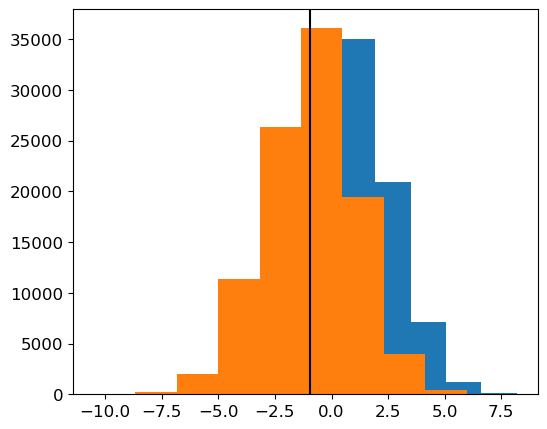

In [559]:
plt.hist(q0)
plt.hist(q1)
plt.axvline(x=Qobs,color='k')
#plt.yscale('log')

In [560]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [561]:
p0 = GetPValue(q0,Qobs,Null = True)
p1 = GetPValue(q1,Qobs,Null = False)
print(p0,p1)

0.16927 0.52378


In [562]:
Clsb = p1
Clb = 1 - p0
print(Clb,Clsb)

0.83073 0.52378


In [563]:
Cls = Clsb/Clb
Cls

0.6305056998061946

In [564]:
# Verdad pero no
#Cls = 1 - pmug
#print(Cls)

In [565]:
SignificanciaH0 = -norm.ppf(p0)
SignificanciaH0

0.9570539997230563

In [566]:
# Veamos la significancia
SignificanciaH1 = norm.ppf(p1)
Significancia

0.2806224435586632

In [567]:
# Deberia se igual a 
S = np.sum(s)
B = np.sum(b)
S/np.sqrt(B+S)

0.9534625892455924

In [518]:
mu = np.linspace(0.5,3,20)

In [519]:
# p-value scan
def GetCls(mu,Expected=False):

    p_value = np.zeros_like(mu)

    for i in tqdm(range(mu.shape[0])):

        Qobs = GetObsJointLnQ(GetLnQ,mu[i],Expected)
        q0,q1 = Sampler(mu[i])

        p0 = GetPValue(q0,Qobs,Null = True)
        p1 = GetPValue(q1,Qobs,Null = False)

        if p0 == 1.:
            print('Problema con este valor:', mu[i])
            pmu = p1
        else:
            pmu = p1 / (1-p0)

        p_value[i] = pmu

    return p_value

In [520]:
Op_value = GetCls(mu,Expected=False)
Ep_value = GetCls(mu,Expected=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.93it/s]


In [521]:
Op_value

array([0.77215524, 0.70122795, 0.62765597, 0.55421704, 0.48703377,
       0.42171255, 0.36222874, 0.31138766, 0.25934842, 0.21450608,
       0.18071099, 0.14531298, 0.11712095, 0.09592127, 0.07371903,
       0.05715931, 0.04472867, 0.03411911, 0.02679609, 0.02050671])

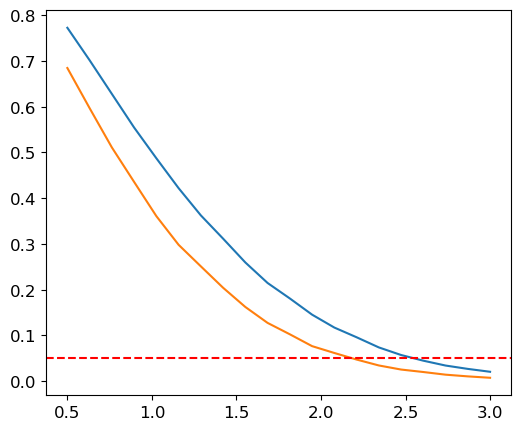

In [522]:
plt.plot(mu,Op_value)
plt.plot(mu,Ep_value)
plt.axhline(y=0.05,ls='--',color='r')

In [523]:
np.linspace(0,2,11)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])